# Import necessary libraries and set seeds

In [3]:
import torch
from tqdm.notebook import tqdm

# from transformers import BertTokenizer
# from torch.utils.data import TensorDataset
# from transformers import BertForSequenceClassification

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
import pandas as pd
import random
import numpy as np
import os
import time # time module 

import json



def set_seed(seed = 1234):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(23456)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # use 'cuda' if available else 'cpu'
print('Working on:', device)

Working on: cuda


# Download Squad2.0

We have already downloaded the datasets from https://rajpurkar.github.io/SQuAD-explorer/ in our drive

In [4]:
Location_squad_train2 = '../input/squad-20/train-v2.0.json'
Location_squad_dev2 = '../input/squad-20/dev-v2.0.json'

# Prepare train and test set

In [5]:
# if num_groups=-1 we will take all the dataset, 
# or we will take the selected number of groups

def read_squad(path, num_groups=-1):
    # open JSON file and load intro dictionary
    with open(path, 'rb') as f:
        squad_dict = json.load(f)

    # initialize lists for contexts, questions, and answers
    contexts = []
    questions = []
    answers = []
    # iterate through all data in squad data
    for group in squad_dict['data']:
        if num_groups <= 0 and num_groups != -1:   
          break 
        for passage in group['paragraphs']:
            context = passage['context']
            for qa in passage['qas']:
                question = qa['question']
                # check if we need to be extracting from 'answers' or 'plausible_answers'
                if 'plausible_answers' in qa.keys():
                    access = 'plausible_answers'
                else:
                    access = 'answers'
                for answer in qa[access]:
                    # append data to lists
                    contexts.append(context)
                    questions.append(question)
                    answers.append(answer)

        if num_groups != -1:
          num_groups -= 1
    # return formatted data lists
    return contexts, questions, answers

In [6]:
# execute our red SQuAD function for training and validation sets

num_groups = -1 # take the first 100 group of contexts/questions/answers from squad

train_contexts, train_questions, train_answers = read_squad(Location_squad_train2, num_groups)
val_contexts, val_questions, val_answers = read_squad(Location_squad_dev2, num_groups)

In [7]:
len(train_contexts), len(train_questions), len(train_answers)   # if we have 1 group we have several questions/answers from the same context

(130319, 130319, 130319)

In [8]:
len(val_contexts), len(val_questions), len(val_answers)   # if we have 1 group we have several questions/answers from the same context

(26232, 26232, 26232)

In [9]:
# Test our data
print(train_contexts[0])
print(train_questions[0])
print(train_answers[0])
print('\n\n')
print(train_contexts[1])
print(train_questions[1])
print(train_answers[1])

Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".
When did Beyonce start becoming popular?
{'text': 'in the late 1990s', 'answer_start': 269}



Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various sin

Contexts for the first 2 questions seems to be the same, but question/answer is different, so we are right.

## Indicate the start and the end of each answer within the context

In [10]:
def add_end_idx(answers, contexts):
    # loop through each answer-context pair
    for answer, context in zip(answers, contexts):
        # gold_text refers to the answer we are expecting to find in context
        gold_text = answer['text']
        # we already know the start index
        start_idx = answer['answer_start']
        # and ideally this would be the end index...
        end_idx = start_idx + len(gold_text)

        # ...however, sometimes squad answers are off by a character or two
        if context[start_idx:end_idx] == gold_text:
            # if the answer is not off :)
            answer['answer_end'] = end_idx
        else:
            # this means the answer is off by 1-2 tokens
            for n in [1, 2]:
                if context[start_idx-n:end_idx-n] == gold_text:
                    answer['answer_start'] = start_idx - n
                    answer['answer_end'] = end_idx - n
            
# and apply the function to our two answer lists
add_end_idx(train_answers, train_contexts)
add_end_idx(val_answers, val_contexts)

In [11]:
train_answers[:5]

[{'text': 'in the late 1990s', 'answer_start': 269, 'answer_end': 286},
 {'text': 'singing and dancing', 'answer_start': 207, 'answer_end': 226},
 {'text': '2003', 'answer_start': 526, 'answer_end': 530},
 {'text': 'Houston, Texas', 'answer_start': 166, 'answer_end': 180},
 {'text': 'late 1990s', 'answer_start': 276, 'answer_end': 286}]

# Tokenization function for Bert and DistilBert

In [12]:
def add_token_positions(encodings, answers):
    # initialize lists to contain the token indices of answer start/end
    start_positions = []
    end_positions = []
    for i in range(len(answers)):
        # append start/end token position using char_to_token method
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end']))

        # if start position is None, the answer passage has been truncated
        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length
        # end position cannot be found, char_to_token found space, so shift position until found
        shift = 1
        while end_positions[-1] is None:
            end_positions[-1] = encodings.char_to_token(i, answers[i]['answer_end'] - shift)
            shift += 1
    # update our encodings object with the new token-based start/end positions
    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

# Initializing the Dataset Squad 

In [13]:
import torch

class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

# DistilBert model

## Tokenization with DistilBertTokenizerFast and Encoding the data

In [12]:
from transformers import DistilBertTokenizerFast
from transformers import AutoTokenizer, BertForQuestionAnswering

# initialize the tokenizer

# first way
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased', 
                                                    do_lower_case=True)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [13]:
# tokenize
train_encodings = tokenizer(train_contexts, 
                            train_questions, 
                            truncation=True,
                            max_length=324, 
                            padding=True )


val_encodings = tokenizer(val_contexts, 
                          val_questions, 
                          truncation=True, 
                          max_length=324,
                          padding=True )

In [14]:
# apply function to our data
add_token_positions(train_encodings, train_answers)
add_token_positions(val_encodings, val_answers)

In [15]:
train_encodings.keys()

dict_keys(['input_ids', 'attention_mask', 'start_positions', 'end_positions'])

In [16]:
# build datasets for both our training and validation sets
train_dataset = SquadDataset(train_encodings)
val_dataset = SquadDataset(val_encodings)

## Dataloaders


In [17]:
from torch.utils.data import DataLoader

# initialize data loader for training data
BATCH_SIZE = 8
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

## Define the DistilBert model

In [18]:
from transformers import DistilBertForQuestionAnswering 

model_DistilBert = DistilBertForQuestionAnswering.from_pretrained('distilbert-base-uncased').to(device)

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this mode

# Evaluation from https://rajpurkar.github.io/SQuAD-explorer/

In [14]:
# Function for exc
def extract_tokens(compressed_tokens, positions):
  tokens = dict()

  sp = positions[0]     # start positions for each answer
  ep = positions[1]     # end positions for each answer (it's not actually the start position, is the first token for the answer)
  
  num_answers = len(sp)
  index = 0
  max_length = len(compressed_tokens['input_ids'][index])   # this is the max_length from tokenizer !
  
  for start, end in zip(sp, ep):  
    tokens[index] = []          # we will fill this list with tokens for each question
    
    start = int(start)
    end = int(end)

    if start > end:
      # print('index: ', index)
      if end <= max_length:    # we have to check it if we have argument max_length in tokenizer
        tokens[index].append(tokenizer.decode(compressed_tokens['input_ids'][index][end]))
      if start <= max_length :
        tokens[index].append(tokenizer.decode(compressed_tokens['input_ids'][index][start]))
    else:
      for i in range(start, end+1):
        # print(i)
        if i <= max_length:
          tokens[index].append(tokenizer.decode(compressed_tokens['input_ids'][index][i]))
    index += 1

  return tokens

In [15]:
import argparse
import collections
import json
import numpy as np
import os
import re
import string
import sys


def normalize_answer(s):
  """Lower text and remove punctuation, articles and extra whitespace."""
  def remove_articles(text):
    regex = re.compile(r'\b(a|an|the)\b', re.UNICODE)
    return re.sub(regex, ' ', text)
  def white_space_fix(text):
    return ' '.join(text.split())
  def remove_punc(text):
    exclude = set(string.punctuation)
    return ''.join(ch for ch in text if ch not in exclude)
  def lower(text):
    return text.lower()
  return white_space_fix(remove_articles(remove_punc(lower(s))))

  
def get_tokens(s):
  if not s: return []
  return normalize_answer(s).split()



def compute_f1(a_gold, a_pred):
    gold_toks = get_tokens(a_gold)
    pred_toks = get_tokens(a_pred)
    common = collections.Counter(gold_toks) & collections.Counter(pred_toks)
    num_same = sum(common.values())
    if len(gold_toks) == 0 or len(pred_toks) == 0:
      # If either is no-answer, then F1 is 1 if they agree, 0 otherwise
      return int(gold_toks == pred_toks)
    if num_same == 0:
      return 0
    precision = 1.0 * num_same / len(pred_toks)
    recall = 1.0 * num_same / len(gold_toks)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1


def compute_f1_score(truth_answers, pred_answers):
    num_answers = len(truth_answers)   # number of answers for batch ( == batch_size)
    total_f1_score = 0

    for curr_answer in range(0, num_answers):    # for each answer compute f1 score
      a_gold = ' '.join(truth_answers[curr_answer])     # get the current truth answer
      a_pred = ' '.join(pred_answers[curr_answer])      # get the current predicted answer

      total_f1_score += compute_f1(a_gold, a_pred)

    return total_f1_score / num_answers


def compute_exact(a_gold, a_pred):
  return int(normalize_answer(a_gold) == normalize_answer(a_pred))


def compute_exact_score(truth_answers, pred_answers):
    num_answers = len(truth_answers)   # number of answers for batch ( == batch_size)
    total_exact_score = 0

    for curr_answer in range(0, num_answers):    # for each answer compute f1 score
      a_gold = ' '.join(truth_answers[curr_answer])     # get the current truth answer
      a_pred = ' '.join(pred_answers[curr_answer])      # get the current predicted answer

      total_exact_score += compute_exact(a_gold, a_pred)

    return total_exact_score / num_answers



## Fine-tuning DistilBert model

In [21]:
from torch.utils.data import DataLoader
from tqdm import tqdm

# initialize adam optimizer with weight decay (reduces chance of overfitting)
optim = torch.optim.AdamW(model_DistilBert.parameters(), lr=2e-5)

epochs = 2


train_losses = []
test_losses = []

for epoch in range(epochs):
    
    train_loss = []
    test_loss = []
    acc_train = []
    acc_test = []

    # for compute f1
    pred_start = []
    pred_end = []
    true_start = []
    true_end = []
    f1_scores = []
    exact_scores = []

    model_DistilBert.train()   # set model to train mode
    with torch.set_grad_enabled(True):
      # setup loop (we use tqdm for the progress bar)
      progress_bar = tqdm(train_loader, f"Epoch: {epoch+1}")
      for batch in progress_bar:
          # initialize calculated gradients (from prev step)
          optim.zero_grad()

          # pull all the tensor batches required for training
          input_ids = batch['input_ids'].to(device)
          attention_mask = batch['attention_mask'].to(device)
          start_positions = batch['start_positions'].to(device)
          end_positions = batch['end_positions'].to(device)

          # print('start_positions', start_positions)
          
          # train model on batch and return outputs (incl. loss)
          outputs = model_DistilBert(input_ids, attention_mask=attention_mask,
                          start_positions=start_positions,
                          end_positions=end_positions)
          
          # get the predictions
          start_pred = torch.argmax(outputs['start_logits'], dim=1)
          end_pred = torch.argmax(outputs['end_logits'], dim=1)

          
          # extract loss
          loss = outputs[0]

          # calculate loss for every parameter that needs grad update
          loss.backward()
          # update parameters
          optim.step()
          train_loss.append(loss.item())

          # calculate accuracy for both and append to accuracy list
          acc_train.append(((start_pred == start_positions).sum()/len(start_pred)).item())
          acc_train.append(((end_pred == end_positions).sum()/len(end_pred)).item())

          # print relevant info to progress bar
          # progress_bar.set_description(f'Epoch {epoch+1}')
          progress_bar.set_postfix({'training_loss': '{:.3f}'.format(np.mean(train_loss))})
    
    # get the average loss
    train_loss_temp = np.mean(train_loss)
    train_losses.append(train_loss_temp)
    
    acc_train_temp = np.mean(acc_train)   # average accuracy of the train set


    model_DistilBert.eval()  # switch model out of training mode
    for batch in val_loader:
        # we don't need to calculate gradients as we're not training
        with torch.no_grad():
            # pull all the tensor batches required for training
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            # we will use true positions for accuracy calc
            start_true = batch['start_positions'].to(device)
            end_true = batch['end_positions'].to(device)


            # train model on batch and return outputs (incl. loss)
            outputs = model_DistilBert(input_ids, attention_mask=attention_mask,
                                start_positions=start_true,
                                end_positions=end_true)
            
            # extract loss
            loss = outputs[0]

            # pull prediction tensors out and argmax to get predicted tokens
            start_pred = torch.argmax(outputs['start_logits'], dim=1)
            end_pred = torch.argmax(outputs['end_logits'], dim=1)

            # ~~~ Compute F1 score with tokens ~~~~
            # extract truth tokens
            truth_positions = [start_true.detach().cpu(), end_true.detach().cpu()]
            truth_tokens = extract_tokens(batch, truth_positions)

            # extract predicted tokens
            pred_positions = [start_pred, end_pred]
            pred_tokens = extract_tokens(batch, pred_positions)

            f1_scores.append (compute_f1_score(truth_tokens, pred_tokens))
            exact_scores.append(compute_exact_score(truth_tokens, pred_tokens))
                      
            test_loss.append(loss.item())



            # calculate accuracy for both and append to accuracy list
            acc_test.append(((start_pred == start_true).sum()/len(start_pred)).item())
            acc_test.append(((end_pred == end_true).sum()/len(end_pred)).item())
            
    # calculate the average test loss
    test_loss_temp = np.mean(test_loss)
    test_losses.append(test_loss_temp)

    # calculate average accuracy in total
    acc_test_temp = np.mean(acc_test)
    f1_score_temp = np.mean(f1_scores)
    exact_score_temp = np.mean(exact_scores)

    

    tqdm.write(f'''Epoch: {epoch+1} | Train Loss: {train_loss_temp:.3f} | Val Loss: {test_loss_temp:.3f} | Train Acc: {acc_train_temp*100:.2f}% | Val Acc: {acc_test_temp*100:.2f}% | Exact Score: {exact_score_temp * 100:.2f}% | F1 Score: {f1_score_temp * 100:.2f}%''')


Epoch: 1: 100%|██████████| 16290/16290 [43:51<00:00,  6.19it/s, training_loss=1.466]


Epoch: 1 | Train Loss: 1.466 | Val Loss: 1.231 | Train Acc: 58.80% | Val Acc: 64.33% | Exact Score: 56.48% | F1 Score: 72.99%


Epoch: 2: 100%|██████████| 16290/16290 [43:51<00:00,  6.19it/s, training_loss=0.942]


Epoch: 2 | Train Loss: 0.942 | Val Loss: 1.256 | Train Acc: 71.27% | Val Acc: 65.11% | Exact Score: 57.91% | F1 Score: 74.23%


In [22]:
val_answers[4]

{'text': '10th and 11th centuries', 'answer_start': 94, 'answer_end': 117}

## Plot train and validation loss for DistilBert model

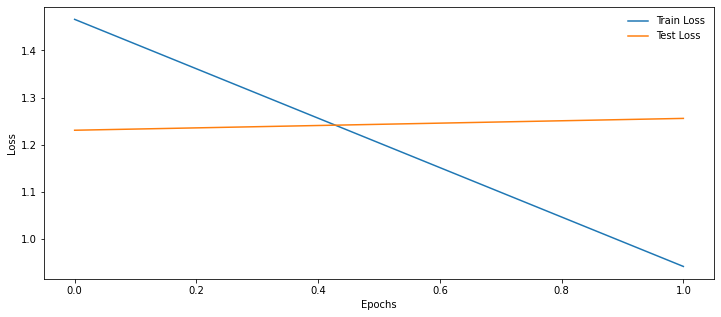

In [23]:
#Plotting loss vs epochs.
plt.figure(figsize=(12, 5))

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend(frameon=False)

# Bert model

## Tokenization with BertTokenizer and Encoding the data

In [1]:
from transformers import AutoTokenizer, BertForQuestionAnswering

# initialize the tokenizer

# Second way
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased",
                                                      do_lower_case=True)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [16]:
# tokenize
train_encodings = tokenizer(train_contexts, 
                            train_questions, 
                            truncation=True,
                            max_length=324, 
                            padding=True)


val_encodings = tokenizer(val_contexts, 
                          val_questions, 
                          truncation=True, 
                          max_length=324,
                          padding=True)

In [17]:
tokenizer.decode(val_encodings['input_ids'][0])[:]

'[CLS] the normans ( norman : nourmands ; french : normands ; latin : normanni ) were the people who in the 10th and 11th centuries gave their name to normandy, a region in france. they were descended from norse ( " norman " comes from " norseman " ) raiders and pirates from denmark, iceland and norway who, under their leader rollo, agreed to swear fealty to king charles iii of west francia. through generations of assimilation and mixing with the native frankish and roman - gaulish populations, their descendants would gradually merge with the carolingian - based cultures of west francia. the distinct cultural and ethnic identity of the normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries. [SEP] in what country is normandy located? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

In [18]:
# apply function to our data
add_token_positions(train_encodings, train_answers)
add_token_positions(val_encodings, val_answers)

In [19]:
train_encodings.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'])

In [20]:
# build datasets for both our training and validation sets
train_dataset = SquadDataset(train_encodings)
val_dataset = SquadDataset(val_encodings)

## Dataloaders


In [21]:
from torch.utils.data import DataLoader

# initialize data loader for training data
BATCH_SIZE = 8
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [22]:
from transformers import BertForQuestionAnswering


model_Bert = BertForQuestionAnswering.from_pretrained('bert-base-uncased').to(device)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForQuestionAnswering: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased a

## Fine-tuning Bert model

In [24]:
from torch.utils.data import DataLoader
from tqdm import tqdm

# initialize adam optimizer with weight decay (reduces chance of overfitting)
optim = torch.optim.AdamW(model_Bert.parameters(), lr=2e-5)

epochs = 2


train_losses = []
test_losses = []

for epoch in range(epochs):
    
    train_loss = []
    test_loss = []
    acc_train = []
    acc_test = []

    # for compute f1
    pred_start = []
    pred_end = []
    true_start = []
    true_end = []
    f1_scores = []
    exact_scores = []

    model_Bert.train()   # set model to train mode
    with torch.set_grad_enabled(True):
      # setup loop (we use tqdm for the progress bar)
      progress_bar = tqdm(train_loader, f"Epoch: {epoch+1}")
      for batch in progress_bar:
          # initialize calculated gradients (from prev step)
          optim.zero_grad()

          # pull all the tensor batches required for training
          input_ids = batch['input_ids'].to(device)
          attention_mask = batch['attention_mask'].to(device)
          start_positions = batch['start_positions'].to(device)
          end_positions = batch['end_positions'].to(device)

          # print('start_positions', start_positions)
          
          # train model on batch and return outputs (incl. loss)
          outputs = model_Bert(input_ids, attention_mask=attention_mask,
                          start_positions=start_positions,
                          end_positions=end_positions)
          
          # get the predictions
          start_pred = torch.argmax(outputs['start_logits'], dim=1)
          end_pred = torch.argmax(outputs['end_logits'], dim=1)

          
          # extract loss
          loss = outputs[0]

          # calculate loss for every parameter that needs grad update
          loss.backward()
          # update parameters
          optim.step()
          train_loss.append(loss.item())

          # calculate accuracy for both and append to accuracy list
          acc_train.append(((start_pred == start_positions).sum()/len(start_pred)).item())
          acc_train.append(((end_pred == end_positions).sum()/len(end_pred)).item())

          # print relevant info to progress bar
          # progress_bar.set_description(f'Epoch {epoch+1}')
          progress_bar.set_postfix({'training_loss': '{:.3f}'.format(np.mean(train_loss))})
    
    # get the average loss
    train_loss_temp = np.mean(train_loss)
    train_losses.append(train_loss_temp)
    
    acc_train_temp = np.mean(acc_train)   # average accuracy of the train set


    model_Bert.eval()  # switch model out of training mode
    for batch in val_loader:
        # we don't need to calculate gradients as we're not training
        with torch.no_grad():
            # pull all the tensor batches required for training
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            # we will use true positions for accuracy calc
            start_true = batch['start_positions'].to(device)
            end_true = batch['end_positions'].to(device)


            # train model on batch and return outputs (incl. loss)
            outputs = model_Bert(input_ids, attention_mask=attention_mask,
                                start_positions=start_true,
                                end_positions=end_true)
            
            # extract loss
            loss = outputs[0]

            # pull prediction tensors out and argmax to get predicted tokens
            start_pred = torch.argmax(outputs['start_logits'], dim=1)
            end_pred = torch.argmax(outputs['end_logits'], dim=1)

            # ~~~ Compute F1 score with tokens ~~~~
            # extract truth tokens
            truth_positions = [start_true.detach().cpu(), end_true.detach().cpu()]
            truth_tokens = extract_tokens(batch, truth_positions)

            # extract predicted tokens
            pred_positions = [start_pred, end_pred]
            pred_tokens = extract_tokens(batch, pred_positions)

            f1_scores.append (compute_f1_score(truth_tokens, pred_tokens))
            exact_scores.append(compute_exact_score(truth_tokens, pred_tokens))
                      
            test_loss.append(loss.item())



            # calculate accuracy for both and append to accuracy list
            acc_test.append(((start_pred == start_true).sum()/len(start_pred)).item())
            acc_test.append(((end_pred == end_true).sum()/len(end_pred)).item())
            
    # calculate the average test loss
    test_loss_temp = np.mean(test_loss)
    test_losses.append(test_loss_temp)

    # calculate average accuracy in total
    acc_test_temp = np.mean(acc_test)
    f1_score_temp = np.mean(f1_scores)
    exact_score_temp = np.mean(exact_scores)

    

    tqdm.write(f'''Epoch: {epoch+1} | Train Loss: {train_loss_temp:.3f} | Val Loss: {test_loss_temp:.3f} | Train Acc: {acc_train_temp*100:.2f}% | Val Acc: {acc_test_temp*100:.2f}% | Exact Score: {exact_score_temp * 100:.2f}% | F1 Score: {f1_score_temp * 100:.2f}%''')


Epoch: 1: 100%|██████████| 16290/16290 [1:23:50<00:00,  3.24it/s, training_loss=1.295]


Epoch: 1 | Train Loss: 1.295 | Val Loss: 1.156 | Train Acc: 63.04% | Val Acc: 67.19% | Exact Score: 59.61% | F1 Score: 76.26%


Epoch: 2: 100%|██████████| 16290/16290 [1:23:54<00:00,  3.24it/s, training_loss=0.824]


Epoch: 2 | Train Loss: 0.824 | Val Loss: 1.161 | Train Acc: 74.58% | Val Acc: 67.83% | Exact Score: 60.63% | F1 Score: 76.74%


## Plot train and validation loss for Bert model

In [ ]:
#Plotting loss vs epochs.
plt.figure(figsize=(12, 5))

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend(frameon=False)